In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from myusefultools.pyopenfoam import OpenFOAM
from pathlib import Path
import multiprocessing as mp
import os
import itertools

In [2]:
## Check CASES folder exists
cases_folder = Path("CASES_10mgDOC")
if not cases_folder.exists():
    os.mkdir(cases_folder)

template_folder = Path("template")

In [3]:
rho_x_list = [1]  ## Values chosen so they are nice powers of 10
d_growth_list = [1e-10]
cases_objs = dict()

## Assemble cases
for rho_x, d_growth in itertools.product(
    rho_x_list, d_growth_list
):

    identifier = cases_folder / f"rhox_{rho_x}__dgrowth_{d_growth}"
    of = OpenFOAM(
        path_case=identifier, write_to_log = True, path_template=template_folder
    )

    of.set_value_in_foamDictionary(
        location="constant/transportProperties", 
        entry="rho_X",
        value=f"rho_X   [1 -3 0 0 0 0 0] {rho_x:.1f}")
    
    of.set_value_in_foamDictionary( 
        location="constant/transportProperties", 
        entry="diffusiveGrowth",
        value=f"diffusiveGrowth [0 2 -1 0 0 0 0] {d_growth:.2e}")

    ## To change the DOC concentration
    of.set_value_in_foamDictionary( 
        location="0.000/DOC", 
        entry="internalField",
        value=f"uniform 5.0E-3")

    of.set_value_in_foamDictionary( 
        location="0.000/DOC", 
        entry="boundaryField.top.uniformInletValue",
        value=f"constant 5.0E-3")

    cases_objs[str(identifier)] = of

In [4]:
cases_objs[str(cases_folder / "rhox_1__dgrowth_1e-10")]

OpenFOAM(path_case=PosixPath('CASES_10mgDOC/rhox_1__dgrowth_1e-10'), path_template=PosixPath('template'), write_to_log=True)

In [5]:
with mp.Pool(processes=24) as pool:
    pool.map(OpenFOAM.run_solver, cases_objs.values())

In [14]:
# Disable if got rid of the cases and need to rerun/convert to vtk

with mp.Pool() as pool:
    pool.map(OpenFOAM.foam_to_vtk, cases_objs.values())

with mp.Pool() as pool:
    pool.map(OpenFOAM.boundaryProbes_to_txt, cases_objs.values())

In [15]:
cases_objs

{'CASES_10mgDOC/rhox_1__dgrowth_1e-10': OpenFOAM(path_case=PosixPath('CASES_10mgDOC/rhox_1__dgrowth_1e-10'), path_template=PosixPath('template'), write_to_log=True)}

In [30]:
h = cases_objs["CASES_10mgDOC/rhox_1__dgrowth_1e-10"].read_field_all_times("h")
Sw = cases_objs["CASES_10mgDOC/rhox_1__dgrowth_1e-10"].read_field_all_times("Sw")


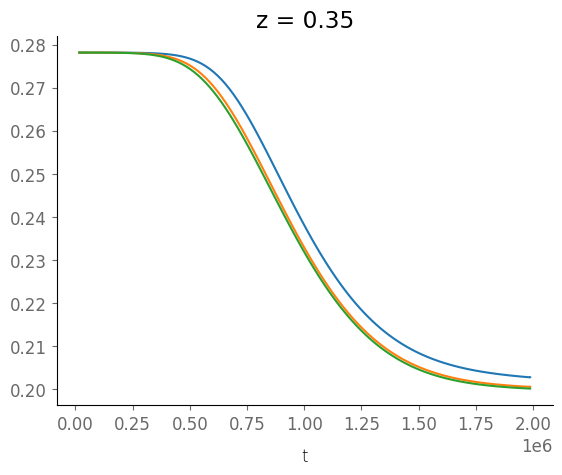

In [31]:
Sw.sel(z=0.55, method="nearest").plot.line()
Sw.sel(z=0.45, method="nearest").plot.line()
Sw.sel(z=0.35, method="nearest").plot.line()


In [ ]:
xar = cases_objs["CASES_10mgDOC/rhox_10__dgrowth_1e-10"].read_field_all_times("XAR")
xeps = cases_objs["CASES_10mgDOC/rhox_10__dgrowth_1e-10"].read_field_all_times("EPS")
xi = cases_objs["CASES_10mgDOC/rhox_10__dgrowth_1e-10"].read_field_all_times("XI")

xarrays = [xar, xeps, xi]
xnames = [r"$X_{\mathsf{ar}}$", r"$X_{\mathsf{eps}}$", r"$X_{\mathsf{in}}$"]

In [ ]:
import matplotlib.colors as colors
cmaps = ["Greens", "Purples", "Greys"]

In [ ]:
igt = 0
fig, (caxs, axs) = plt.subplots(
    2, 3, figsize=[15, 5], dpi=120,
    gridspec_kw={"height_ratios": [0.2, 5]}, sharex="row", sharey="row"
)

for ax,cax,cmap,scalar,name in zip(axs, caxs, cmaps, xarrays, xnames):
    img = ax.pcolormesh(
        scalar.t[igt:] / 86400, scalar.z, scalar[:, igt:], 
        norm=colors.LogNorm(5e-5, 1e-0), cmap=cmap
    )
    ax.spines.right.set_visible(False)
    ax.set_xlabel("Time $t$ [d]")
    ax.set_ylabel("Depth $z$ [m]")
    plt.colorbar(img, cax=cax, orientation="horizontal")
    cax.set_title(rf"{name} [g/L]")
fig.tight_layout()
plt.show()

In [ ]:
from matplotlib.ticker import LogLocator
from math import log10
linecolors = ["forestgreen", "purple", "grey"]

fig, ax = plt.subplots(figsize=(6,5), dpi=100)
display_label = False
dvalues = list()

for scalar, name, linecolor in zip(xarrays, xnames, linecolors):
    ax.plot(scalar.isel(t=-1), scalar.z, alpha=0.9, lw=3, label=name, c=linecolor)

ax.set_xscale("log")
ax.set_xlim(2e-6, 1e-0)
ax.set_ylim(bottom=0)
ax.set_ylabel("Depth [m]")
ax.set_xlabel(r"Active biomass $X_{\mathsf{AR}}$ [g/L]")
# ax.xaxis.set_major_locator(LogLocator())
# ax.xaxis.set_minor_locator(LogLocator(subs="all"))
ax.legend(title="Immobile biomass\n[g/L]", title_fontproperties=dict(size=10, weight=100), loc="lower right", bbox_to_anchor=(1, 0.14))
# ax.tick_params(axis="both", which="minor", width=1, length=10, color="k")


# ax2 = ax.twiny()
# ax2.errorbar(cfu["CFU/mL"], cfu["z (m)"], xerr=cfu["stdev"], fmt="none", ecolor="gray", capsize=2)
# ax2.plot(cfu["CFU/mL"], cfu["z (m)"], marker="o", markersize=5, c="gray", lw=1, ls="dashed", label="Inoculated column")
# ax2.set_xscale("log")
# ax2.set_ylim(ax.get_ylim())
# ax2.spines.top.set_visible(True)
# ax2.set_xlim(1e+7, 1e+10)
# ax2.set_xlabel(r"Microbial counts [CFU/mL]")
# leg = ax2.legend(title="Experimental data", title_fontproperties=dict(size=10, weight=100), loc="lower right")
# fig.savefig("XAR by kappa.pdf", bbox_inches='tight')
plt.show()

In [ ]:
scalar

In [ ]:
scalar.t